<a href="https://colab.research.google.com/github/et-tran50/CASE/blob/main/SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install imbalanced-learn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import shap
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE

In [ ]:
train_data = pd.read_csv('/content/Training Dataset A_R-384922_Candidate Attach #1_PresSE_SRF #1141.csv')
eval_data = pd.read_csv('/content/Evaluation Dataset B_R-384922_Candidate Attach #2_PresSE_SRF #1141.csv')

In [ ]:
# Separate features and target variable
y = train_data['aprv_flag']  # Keep target separately
X = train_data.drop(columns=['aprv_flag'])  # Drop target column
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [ ]:
# MICE imputer for NAN data
mice_imputer = IterativeImputer(max_iter=10, random_state=0)
X_imputed = mice_imputer.fit_transform(X_encoded)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Initialize logistic regression with L1 penalty
model = LogisticRegression(penalty='l1', class_weight = 'balanced', solver='liblinear', max_iter=1000)

# Perform GridSearchCV to find the best C
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, verbose=1)
grid_search.fit(X_train_smote, y_train_smote)

# Step 6: Get the best model and evaluate
best_model = grid_search.best_estimator_
print(f"Best C: {grid_search.best_params_}")

# Predict on the test set
y_pred = best_model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C: {'C': 1}
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.78      0.64      1696
           1       0.91      0.76      0.83      4786

    accuracy                           0.77      6482
   macro avg       0.72      0.77      0.73      6482
weighted avg       0.81      0.77      0.78      6482



In [ ]:
validation_accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Validation Accuracy: 0.7650
Precision: 0.9086
Recall: 0.7580
F1-Score: 0.8265


In [ ]:
# Apply the same preprocessing steps to Dataset B

X_eval = eval_data.drop(columns=['aprv_flag'])  # Separate features and target
y_eval = eval_data['aprv_flag']

X_eval_encoded = pd.get_dummies(X_eval, columns=categorical_cols, drop_first=True)

# Ensure the evaluation data has the same columns as the training data after encoding
X_eval_encoded = X_eval_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Impute and scale the evaluation dataset using the training data transformations
X_eval_imputed = mice_imputer.transform(X_eval_encoded)
X_eval_scaled = scaler.transform(X_eval_imputed)
scaler = StandardScaler()
X_eval_scaled = scaler.fit_transform(X_eval_imputed)

#Evaluate the Model on the Evaluation Dataset
y_eval_pred = best_model.predict(X_eval_scaled)
evaluation_accuracy = accuracy_score(y_eval, y_eval_pred)
print(f"Evaluation Accuracy: {evaluation_accuracy:.4f}")

Evaluation Accuracy: 0.7511


In [ ]:
y_probs = best_model.predict_proba(X_train)[:, 1]

# Apply the custom threshold
custom_threshold = 0.35  # Replace with your chosen threshold
y_pred = (y_probs >= custom_threshold).astype(int)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_train, y_pred))

# Additional Metrics
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      3958
           1       0.87      0.88      0.88     11166

    accuracy                           0.82     15124
   macro avg       0.76      0.76      0.76     15124
weighted avg       0.81      0.82      0.82     15124

Precision: 0.87
Recall: 0.88
F1-Score: 0.88


/usr/local/lib/python3.10/dist-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


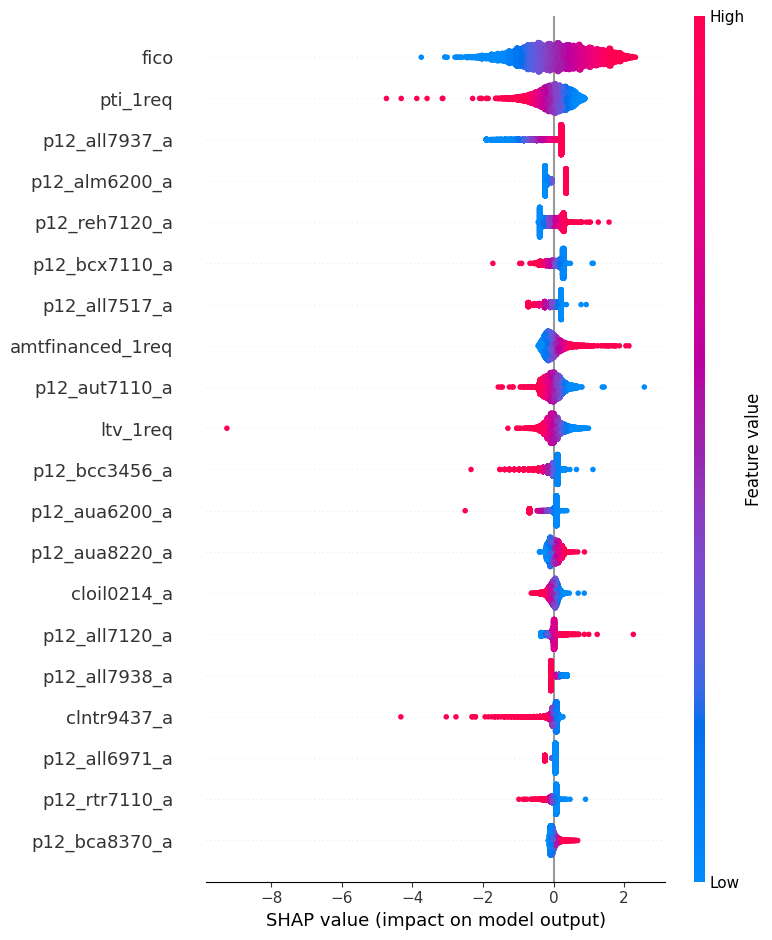

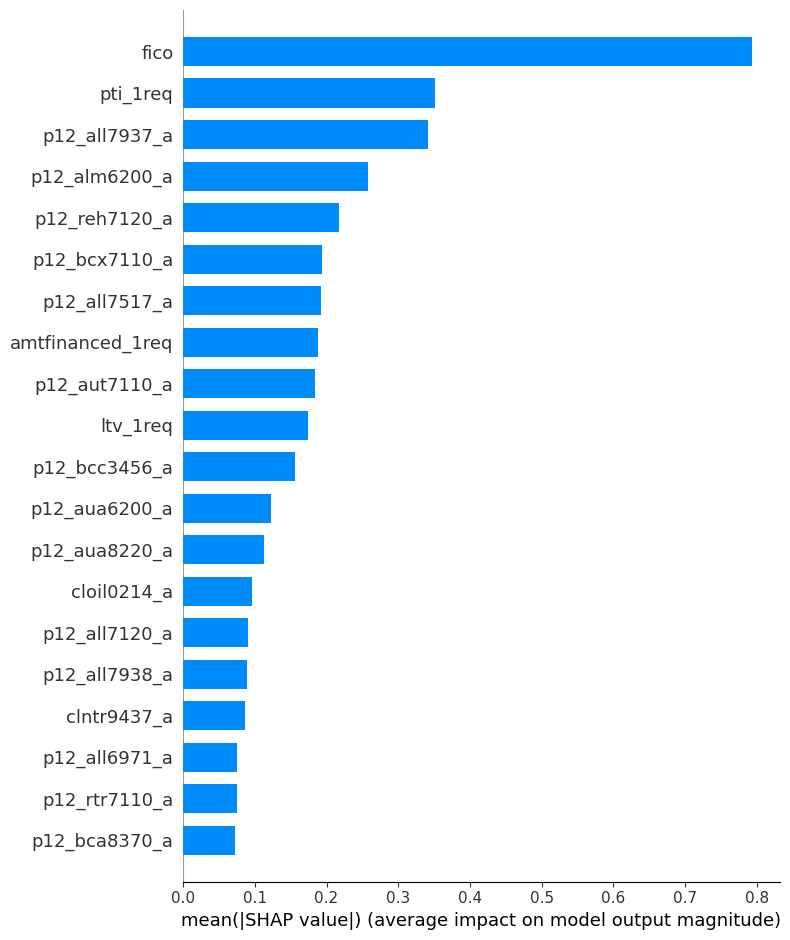

In [ ]:
explainer = shap.LinearExplainer(best_model, X_train, feature_perturbation="interventional")

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_test)
#Summary Plot for Feature Importance
shap.summary_plot(shap_values, X_test, feature_names=X_encoded.columns)

# Alternatively, use a bar plot to display overall feature importance
shap.summary_plot(shap_values, X_test, feature_names=X_encoded.columns, plot_type="bar")